In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [ ]:
import pandas as pd
import re
import numpy as np
import itertools
import collections
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud

import nltk
nltk.download('treebank')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 

import gensim
from gensim.models import KeyedVectors, Word2Vec, FastText

import tensorflow as tf
import unicodedata

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
train_df = pd.read_csv("tam_sentiment_train.tsv", sep='\t')
print(len(train_df))

valid_df = pd.read_csv("tam_sentiment_dev.tsv", sep='\t')
print(len(valid_df))

test_df = pd.read_csv("sen_tam_test_without_labels.tsv", sep='\t')
len(test_df)

35656
3962


649

In [ ]:
test_df

,id,Text
0,TAM_01,இது புதுவகை கொள்ளை கூட்டம்
1,TAM_02,சுட்டுக்கொல்ல வேண்டும் அல்லது குண்டர் சட்டத்தி...
2,TAM_03,இந்த திருநங்கைகள் பொதுமக்களுக்கு பொது இடங்களில...
3,TAM_04,அராஜகம் செய்து தங்களுடைய மதிப்பை தாங்களே கெடுத...
4,TAM_05,தவறான விடையம் சகோ...அந்த பொண்டுகப் புண்டாமகன்ள...
...,...,...
644,TAM_645,பல நாள் திருடன் ஒரு நாள் அகப்படுவான்
645,TAM_646,"கர்நாடாகாவில் இருந்து தமிழர்களை,காவிரி பிரச்சன..."
646,TAM_647,"கருணா பெயர் கொண்ட நாடு, கறு நாடு அகம்."
647,TAM_648,@Thamizhmuckkan venkatraman RN கார் (மழை) + நா...


In [ ]:
print(test_df['Text'][279])
print(test_df['Text'][516])
print(test_df['Text'][546])
print(test_df['Text'][555])
print(test_df['Text'][559])
print(test_df['Text'][570])

திருநங்கை இல்லை திருட்டுநங்கைனு சொல்லுங்க ஐய்ந்து ரூபாய் கொடுத்தால் வாங்க மாட்டானுக பத்துரூபாய்தான் வேனுமாம் என் கடையில் என் மனைவியிடம் பலமுறை பிரச்சனை பன்னிருக்கானுக கையில சிக்கல சிக்குரப்போ இருக்கு வாணவேடிக்கை
காவல்துறைக்கு இதெல்லாம் கண்ணுக்கு தெரியாதா.....
அதுல வெஷத்த கலக்க வச்சுடாதிங்க
அசிங்கமாக திட்டுவார்கள் கொலையும் செய்வார்கள்
Nanum oru thirunangai than yaro oru silar ipdi nadanthatharku ottu motha maguthayum ilivaga pesuvathi niruthungal avargal apdi nadanthukolla anga enna nadanthathu endru namakku yarukum theriyathu avarkal odrum araka manam komdavargal ilai athai mothalil Nan Ariya vendum angal,pengalilum iraka matra seyalgal sribavargal irukindrargal atharuku avargal mothathayum solla mudiyuma ?
Indha mathiri pannuradha Partha mariyadhaiye pogudhu chi 😠😠😠


In [ ]:
train_df['text'][0]

'Vani bhojam fans hit like solli 500 like Vangida Vendiyathu than'

In [ ]:
train_df

,text,category
0,Vani bhojam fans hit like solli 500 like Vangi...,unknown_state
1,I love you ajith very I like,Positive
2,ennaya trailer Ku mudi Ellam nikkudhu... Vera ...,Positive
3,Vijay Annaa Ur Maassssss Therrrrriiiiii,Positive
4,நம்ப நடே நாசாமா தான் போச்சி,Negative
...,...,...
35651,ஒருவர் செய்த தவறுக்காக எல்லாரையும் பழி போடுவது...,Mixed_feelings
35652,Repeated Mode to Watching Theri Trailer & Ther...,Positive
35653,yeevanikuachu pula kutti erudhal oodi poyidu....,Negative
35654,She is looking like laughing budha,Positive


In [ ]:
train_df['category'].value_counts()

Positive          20069
unknown_state      5628
Negative           4271
Mixed_feelings     4020
not-Tamil          1667
Positive              1
Name: category, dtype: int64

In [ ]:
valid_df['category'].value_counts()

Positive          2257
unknown_state      611
Negative           480
Mixed_feelings     438
not-Tamil          176
Name: category, dtype: int64

In [ ]:
valid_df

,text,category
0,@0:40 songsuperb..kamallllla.. I'm waiting fo...,unknown_state
1,கணத்ததோர் அகமுடையார் சார்பாக படம் வெற்றி அடைய...,Positive
2,Thalavia neenga veera level boss and neega tha...,Positive
3,Oru padam patha fell.vera level music,Positive
4,Hairstyle than mattama iruku. Adhu mattum math...,unknown_state
...,...,...
3957,நாடக காதல் மிகப்பெரிய தவறு. இதை தான் இந்த படம்...,Positive
3958,So long to see you suriya,not-Tamil
3959,Super sK ettan adipoli makkalle dec20 waiti...,Mixed_feelings
3960,Minimum 50m viewa vara veppoma all thala fans,Positive


In [ ]:
valid_df['text']

0       @0:40 songsuperb..kamallllla..  I'm waiting fo...
1       கணத்ததோர் அகமுடையார் சார்பாக  படம் வெற்றி அடைய...
2       Thalavia neenga veera level boss and neega tha...
3                   Oru padam patha fell.vera level music
4       Hairstyle than mattama iruku. Adhu mattum math...
                              ...                        
3957    நாடக காதல் மிகப்பெரிய தவறு. இதை தான் இந்த படம்...
3958                            So long to see you suriya
3959    Super  sK  ettan adipoli makkalle dec20  waiti...
3960        Minimum 50m viewa vara veppoma all thala fans
3961                       Vera Vera level da version 2.0
Name: text, Length: 3962, dtype: object

In [ ]:
len(train_df)

35656

In [ ]:
for i in range(len(train_df)):
  if (train_df['category'][i] == 'Positive '):
    print(i)

32852


In [ ]:
train_df['category'][32852]

'Positive '

In [ ]:
train_df['category'][32852] = 'Positive'
train_df['category'][32852]

'Positive'

In [ ]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


for i in range(len(train_df)):
    temp1 = deEmojify(train_df['text'][i])
    train_df['text'][i] = temp1

for j in range(len(valid_df)):
    temp2 = deEmojify(valid_df['text'][j])
    valid_df['text'][j] = temp2

for k in range(len(test_df)):
    temp3 = deEmojify(test_df['Text'][k])
    test_df['Text'][k]=temp3

In [ ]:
print(test_df['Text'][516])
print(test_df['Text'][546])
print(test_df['Text'][555])
print(test_df['Text'][559])
print(test_df['Text'][570])

காவல்துறைக்கு இதெல்லாம் கண்ணுக்கு தெரியாதா.....
அதுல வெஷத்த கலக்க வச்சுடாதிங்க
அசிங்கமாக திட்டுவார்கள் கொலையும் செய்வார்கள்
Nanum oru thirunangai than yaro oru silar ipdi nadanthatharku ottu motha maguthayum ilivaga pesuvathi niruthungal avargal apdi nadanthukolla anga enna nadanthathu endru namakku yarukum theriyathu avarkal odrum araka manam komdavargal ilai athai mothalil Nan Ariya vendum angal,pengalilum iraka matra seyalgal sribavargal irukindrargal atharuku avargal mothathayum solla mudiyuma ?
Indha mathiri pannuradha Partha mariyadhaiye pogudhu chi 


In [ ]:
def preprocess_data(text):
  user_name = '@[A-Za-z0-9]+' # Pattern for matching the user names in the tweet
  has_tag = '#[A-Za-z0-9]+' # Pattern for matching the hasgtags in the tweer
  url = 'https?:\/\/[A-Za-z0-9\.\/\-]+' # Pattern for matching the URLs in the tweet
  #emoji_pattern = r'/[x{1F600}-x{1F64F}]/u'
  
  x = text.lower()  # Lower casing all the characters
  x = re.sub(user_name, '', x) # Replace the username with an empty characrer
  x = re.sub(has_tag,'',x) # Replace the hashtags with an empty characrer
  x = re.sub(url, '', x) # Replace the URLs with an empty characrer
  #x = re.sub(emoji_pattern, '', x)
  x = x.translate(str.maketrans('', '', string.punctuation)) # Replace all the characters except alphabets and digits from the tweet

  return x

In [ ]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
valid_df['text'] = valid_df['text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe
test_df['Text'] = test_df['Text'].apply(lambda x: preprocess_data(x)) # Apply the clean_data() to all the entries in the dataframe

In [ ]:
print(test_df['Text'][279])
print(test_df['Text'][516])
print(test_df['Text'][546])
print(test_df['Text'][555])
print(test_df['Text'][559])
print(test_df['Text'][570])

திருநங்கை இல்லை திருட்டுநங்கைனு சொல்லுங்க ஐய்ந்து ரூபாய் கொடுத்தால் வாங்க மாட்டானுக பத்துரூபாய்தான் வேனுமாம் என் கடையில் என் மனைவியிடம் பலமுறை பிரச்சனை பன்னிருக்கானுக கையில சிக்கல சிக்குரப்போ இருக்கு வாணவேடிக்கை
காவல்துறைக்கு இதெல்லாம் கண்ணுக்கு தெரியாதா
அதுல வெஷத்த கலக்க வச்சுடாதிங்க
அசிங்கமாக திட்டுவார்கள் கொலையும் செய்வார்கள்
nanum oru thirunangai than yaro oru silar ipdi nadanthatharku ottu motha maguthayum ilivaga pesuvathi niruthungal avargal apdi nadanthukolla anga enna nadanthathu endru namakku yarukum theriyathu avarkal odrum araka manam komdavargal ilai athai mothalil nan ariya vendum angalpengalilum iraka matra seyalgal sribavargal irukindrargal atharuku avargal mothathayum solla mudiyuma 
indha mathiri pannuradha partha mariyadhaiye pogudhu chi 


In [ ]:
valid_df['text'][0]

'40 songsuperbkamallllla  im waiting for dis song you'

In [ ]:
print(train_df)
print()
#print(valid_df.head())
#print()
print(valid_df)
print()
print(test_df)

                                                    text        category
0      vani bhojam fans hit like solli 500 like vangi...   unknown_state
1                           i love you ajith very i like        Positive
2      ennaya trailer ku mudi ellam nikkudhu vera lev...        Positive
3               vijay annaa  ur maassssss therrrrriiiiii        Positive
4                            நம்ப நடே நாசாமா தான் போச்சி        Negative
...                                                  ...             ...
35651  ஒருவர் செய்த தவறுக்காக எல்லாரையும் பழி போடுவது...  Mixed_feelings
35652  repeated mode to watching theri trailer  theri...        Positive
35653  yeevanikuachu  pula kutti erudhal oodi poyidu ...        Negative
35654                 she is looking like laughing budha        Positive
35655                     north or south kgf is the best        Positive

[35656 rows x 2 columns]

                                                   text        category
0     40 songsuperbkamall

In [ ]:
train_text = train_df['text'].tolist()
valid_text = valid_df['text'].tolist()
test_text = test_df['Text'].tolist()

train_label = train_df['category'].tolist()
valid_label = valid_df['category'].tolist()

In [ ]:
test_text

['இது புதுவகை கொள்ளை கூட்டம்',
 'சுட்டுக்கொல்ல வேண்டும் அல்லது குண்டர் சட்டத்தில் கைது செய்ய வேண்டும்',
 'இந்த திருநங்கைகள் பொதுமக்களுக்கு பொது இடங்களில் பெரும் தொல்லையாக உள்ளார்கள்',
 'அராஜகம் செய்து தங்களுடைய மதிப்பை தாங்களே கெடுத்துக்கொள்கிறார்கள்',
 'தவறான விடையம் சகோஅந்த பொண்டுகப் புண்டாமகன்ளுக்கு என்ன மதிப்பு இருந்துச்சு',
 'romba thollai pannuthunga yaarume ketka matangala',
 'இதற்கு அரசாங்கமும் பொது மக்களும் இணைந்து ஒரு வழி செய்ய வேண்டும்  மிக கடுமையான நடவடிக்கை தேவை',
 'பெங்களூரில் எங்க வீட்டு திருமணத்தில் இதேமாதிரி தொல்லை நடந்தது',
 'yenna pannenga apro',
 'ennoda anna mareagla kooda 2000 rupa kuduthadha povom illana sabam vitruvomnu mirattunanga',
 'இப்போது இந்த 9தொல்லை அதிகமாக ஆயிருச்சு',
 'என்று சொல்லாதீர்கள் திருநங்கை என்று கூறுங்கள் முதலில்',
 'intha alinga vala thaguthi illatha jenmanga intha ulagathula chi enna karumamo ipdi thollai pannuthunga',
 'ஆமாங்க சரியாக சொன்னீங்க',
 'பணம் கொடுத்து பத்தல கேட்கலாம் ஆனால் பிரச்சினை வர வைப்பது இதற்கென்று மறைமுக துணை அடி ஆட்களும் இ

In [ ]:
class_names = list(set(train_label))
class_names

['Positive', 'Mixed_feelings', 'not-Tamil', 'unknown_state', 'Negative']

In [ ]:
len(train_label)

35656

In [ ]:
class_dist = Counter(train_label)
class_dist

Counter({'unknown_state': 5628,
         'Positive': 20070,
         'Negative': 4271,
         'Mixed_feelings': 4020,
         'not-Tamil': 1667})

In [ ]:
class_dist = Counter(valid_label)
class_dist

Counter({'unknown_state': 611,
         'Positive': 2257,
         'Mixed_feelings': 438,
         'Negative': 480,
         'not-Tamil': 176})

In [ ]:
le = LabelEncoder()

train_label = le.fit_transform(train_label)
train_label

array([4, 2, 2, ..., 1, 2, 2])

In [ ]:
valid_label = le.fit_transform(valid_label)
valid_label

array([4, 2, 2, ..., 0, 2, 2])

In [ ]:
le.inverse_transform([0,1,2,3,4])

array(['Mixed_feelings', 'Negative', 'Positive', 'not-Tamil',
       'unknown_state'], dtype='<U14')

In [ ]:
class_weight = {0:sum(class_dist.values())/class_dist[le.inverse_transform([0])[0]],
                1:sum(class_dist.values())/class_dist[le.inverse_transform([1])[0]],
                2:sum(class_dist.values())/class_dist[le.inverse_transform([2])[0]],
                3:sum(class_dist.values())/class_dist[le.inverse_transform([3])[0]],
                4:sum(class_dist.values())/class_dist[le.inverse_transform([4])[0]]}

class_weight

{0: 9.045662100456621,
 1: 8.254166666666666,
 2: 1.7554275587062473,
 3: 22.511363636363637,
 4: 6.484451718494272}

In [ ]:
training_labels = tf.keras.utils.to_categorical(train_label)
validation_labels = tf.keras.utils.to_categorical(valid_label)

In [ ]:
words_in_train = [sent.split() for sent in train_text] # Splitting the tweet into tokens
words_in_train[0:5]

[['vani',
  'bhojam',
  'fans',
  'hit',
  'like',
  'solli',
  '500',
  'like',
  'vangida',
  'vendiyathu',
  'than'],
 ['i', 'love', 'you', 'ajith', 'very', 'i', 'like'],
 ['ennaya',
  'trailer',
  'ku',
  'mudi',
  'ellam',
  'nikkudhu',
  'vera',
  'level',
  'trailer'],
 ['vijay', 'annaa', 'ur', 'maassssss', 'therrrrriiiiii'],
 ['நம்ப', 'நடே', 'நாசாமா', 'தான்', 'போச்சி']]

In [ ]:
words_in_valid = [sent.split() for sent in valid_text] # Splitting the tweet into tokens
words_in_valid[0:5]

[['40', 'songsuperbkamallllla', 'im', 'waiting', 'for', 'dis', 'song', 'you'],
 ['கணத்ததோர்',
  'அகமுடையார்',
  'சார்பாக',
  'படம்',
  'வெற்றி',
  'அடைய',
  'வாழ்த்துகள்'],
 ['thalavia',
  'neenga',
  'veera',
  'level',
  'boss',
  'and',
  'neega',
  'thaan',
  'marana',
  'mass'],
 ['oru', 'padam', 'patha', 'fellvera', 'level', 'music'],
 ['hairstyle',
  'than',
  'mattama',
  'iruku',
  'adhu',
  'mattum',
  'mathirukalaam',
  'teaser',
  'paakurapo',
  'vettaikaran',
  'padam',
  'maari',
  'theridhu']]

In [ ]:
words_in_test = [sent.split() for sent in test_text] # Splitting the tweet into tokens
words_in_test[0:5]

[['இது', 'புதுவகை', 'கொள்ளை', 'கூட்டம்'],
 ['சுட்டுக்கொல்ல',
  'வேண்டும்',
  'அல்லது',
  'குண்டர்',
  'சட்டத்தில்',
  'கைது',
  'செய்ய',
  'வேண்டும்'],
 ['இந்த',
  'திருநங்கைகள்',
  'பொதுமக்களுக்கு',
  'பொது',
  'இடங்களில்',
  'பெரும்',
  'தொல்லையாக',
  'உள்ளார்கள்'],
 ['அராஜகம்',
  'செய்து',
  'தங்களுடைய',
  'மதிப்பை',
  'தாங்களே',
  'கெடுத்துக்கொள்கிறார்கள்'],
 ['தவறான',
  'விடையம்',
  'சகோஅந்த',
  'பொண்டுகப்',
  'புண்டாமகன்ளுக்கு',
  'என்ன',
  'மதிப்பு',
  'இருந்துச்சு']]

In [ ]:
all_words_train = list(itertools.chain(*words_in_train)) # Making a flatlist of all the words in the corpus
all_words_train[0:10]

['vani',
 'bhojam',
 'fans',
 'hit',
 'like',
 'solli',
 '500',
 'like',
 'vangida',
 'vendiyathu']

In [ ]:
all_words_valid = list(itertools.chain(*words_in_valid)) # Making a flatlist of all the words in the corpus
all_words_valid[0:10]

['40',
 'songsuperbkamallllla',
 'im',
 'waiting',
 'for',
 'dis',
 'song',
 'you',
 'கணத்ததோர்',
 'அகமுடையார்']

In [ ]:
all_words_test = list(itertools.chain(*words_in_test)) # Making a flatlist of all the words in the corpus
all_words_test[0:10]

['இது',
 'புதுவகை',
 'கொள்ளை',
 'கூட்டம்',
 'சுட்டுக்கொல்ல',
 'வேண்டும்',
 'அல்லது',
 'குண்டர்',
 'சட்டத்தில்',
 'கைது']

In [ ]:
word_counts_train = collections.Counter(all_words_train)  # Computing the number of occurrence of all the words in the corpus
word_counts_train.most_common(15)

[('like', 3872),
 ('thala', 3309),
 ('trailer', 2709),
 ('mass', 2600),
 ('vera', 2525),
 ('la', 2195),
 ('படம்', 2160),
 ('movie', 2154),
 ('padam', 2144),
 ('level', 2104),
 ('da', 2056),
 ('fans', 1937),
 ('வாழ்த்துக்கள்', 1776),
 ('ah', 1727),
 ('super', 1656)]

In [ ]:
word_counts_valid = collections.Counter(all_words_valid)  # Computing the number of occurrence of all the words in the corpus
word_counts_valid.most_common(15)

[('like', 432),
 ('thala', 373),
 ('trailer', 318),
 ('vera', 280),
 ('mass', 276),
 ('படம்', 267),
 ('level', 248),
 ('da', 244),
 ('movie', 243),
 ('padam', 220),
 ('la', 219),
 ('வாழ்த்துக்கள்', 214),
 ('surya', 205),
 ('fans', 196),
 ('anna', 172)]

In [ ]:
word_counts_valid = collections.Counter(all_words_test)  # Computing the number of occurrence of all the words in the corpus
word_counts_valid.most_common(15)

[('வேண்டும்', 71),
 ('இவர்கள்', 61),
 ('தான்', 60),
 ('இந்த', 50),
 ('ஒரு', 41),
 ('they', 39),
 ('la', 38),
 ('and', 37),
 ('பணம்', 33),
 ('the', 31),
 ('இவர்களை', 30),
 ('in', 29),
 ('to', 28),
 ('என்று', 27),
 ('is', 25)]

In [ ]:
words_with_counts_train = pd.DataFrame(word_counts_train.most_common(len(all_words_train)), columns=['words', 'count']) 
print(words_with_counts_train.head())

     words  count
0     like   3872
1    thala   3309
2  trailer   2709
3     mass   2600
4     vera   2525


In [ ]:
words_with_counts_valid = pd.DataFrame(word_counts_valid.most_common(len(all_words_valid)), columns=['words', 'count']) 
print(words_with_counts_valid.head())

      words  count
0  வேண்டும்     71
1   இவர்கள்     61
2      தான்     60
3      இந்த     50
4       ஒரு     41


In [ ]:
words_with_counts_test = pd.DataFrame(word_counts_valid.most_common(len(all_words_valid)), columns=['words', 'count']) 
print(words_with_counts_valid.head())

      words  count
0  வேண்டும்     71
1   இவர்கள்     61
2      தான்     60
3      இந்த     50
4       ஒரு     41


In [ ]:
all_words = all_words_train + all_words_valid + all_words_test
corpus = train_text + valid_text + test_text
vocab_size = len(set(all_words)) # number of words to keep.
embedding_dim = 100 # Dimension of the vector representation for each word 
max_length = 0
for i in range(len(corpus)):
  x = word_tokenize(corpus[i])
  if len(x) > max_length:
    max_length = len(x)

oov_tok = "<OOV>"

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_text)
word_index = tokenizer.word_index

In [ ]:
training_sequences = tokenizer.texts_to_sequences(train_text)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(training_sequences,maxlen=max_length, padding='post')

valid_sequences = tokenizer.texts_to_sequences(valid_text)
valid_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_sequences,maxlen=max_length, padding='post')


test_sequences = tokenizer.texts_to_sequences(test_text)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences,maxlen=max_length, padding='post')

In [ ]:
METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

In [ ]:
print(np.shape(training_padded))
print(np.shape(valid_padded))
print(np.shape(test_padded))

(35656, 178)
(3962, 178)
(649, 178)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length,
                              embeddings_initializer='orthogonal', embeddings_regularizer='L2'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=METRICS
)

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 178, 100)          7863300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 7,897,673
Trainable params: 7,897,673
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)

num_epochs = 2
history = model.fit(
    training_padded,
    training_labels,
    epochs=num_epochs,
    batch_size = 256,
    callbacks=[callback],
    validation_data=(valid_padded, validation_labels),
    class_weight=class_weight
)

Epoch 1/2
140/140 [==============================] - 92s 621ms/step - loss: 9.6890 - accuracy: 0.8162 - precision: 0.6663 - recall: 0.1624 - auc: 0.7202 - val_loss: 5.4115 - val_accuracy: 0.8165 - val_precision: 0.6589 - val_recall: 0.1706 - val_auc: 0.7306
Epoch 2/2
140/140 [==============================] - 86s 616ms/step - loss: 10.4880 - accuracy: 0.8262 - precision: 0.6850 - recall: 0.2422 - auc: 0.7649 - val_loss: 5.7930 - val_accuracy: 0.8260 - val_precision: 0.6998 - val_recall: 0.2277 - val_auc: 0.7584


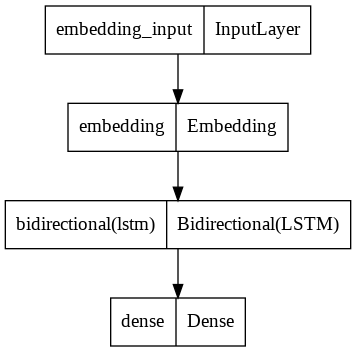

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

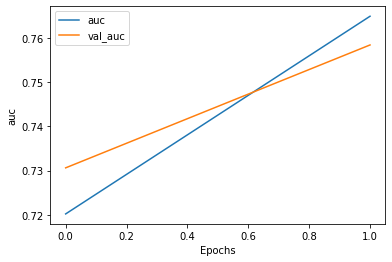

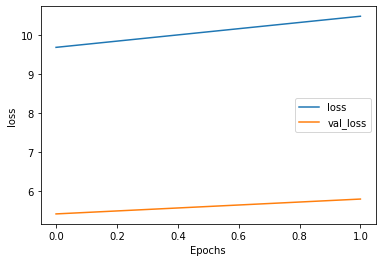

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "auc")
plot_graphs(history, "loss")

In [ ]:
score = model.evaluate(valid_padded, validation_labels)
print("Loss = {}".format(score[0]))
print("Accuracy = {0:.2f}%".format(score[1]*100))
print(score)

124/124 [==============================] - 9s 77ms/step - loss: 5.7930 - accuracy: 0.8260 - precision: 0.6998 - recall: 0.2277 - auc: 0.7584
Loss = 5.793034076690674
Accuracy = 82.60%
[5.793034076690674, 0.8259969353675842, 0.6997672319412231, 0.2276628017425537, 0.7584295868873596]


In [ ]:
y_pred = np.argmax(model.predict(valid_padded), axis=1)
classes_y = np.argmax(y_pred,axis=-1)
accuracy = accuracy_score(valid_label, y_pred)
precision = precision_score(valid_label, y_pred, average='macro')
recall = recall_score(valid_label, y_pred, average='macro')
f1 = f1_score(valid_label, y_pred, average='macro')

print("Accuracy = {0:.2f}".format(accuracy*100))
print("Precision = {0:.4f}".format(precision))
print("Recall = {0:.4f}".format(recall))
print("F1-score = {0:.4f}".format(f1))

Accuracy = 47.02
Precision = 0.4049
Recall = 0.5150
F1-score = 0.4138


In [ ]:
confusion_matrix(valid_label,y_pred)

array([[ 153,  107,   78,   32,   68],
       [  95,  240,   35,   29,   81],
       [ 273,  284, 1051,  255,  394],
       [   4,    8,    6,  142,   16],
       [ 115,   92,   55,   72,  277]])

In [ ]:
print(classification_report(valid_label,y_pred))

              precision    recall  f1-score   support

           0       0.24      0.35      0.28       438
           1       0.33      0.50      0.40       480
           2       0.86      0.47      0.60      2257
           3       0.27      0.81      0.40       176
           4       0.33      0.45      0.38       611

    accuracy                           0.47      3962
   macro avg       0.40      0.52      0.41      3962
weighted avg       0.62      0.47      0.50      3962



In [ ]:
def predict_review(model, reviews):
  # Create the sequences
  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = tf.keras.preprocessing.sequence.pad_sequences(sample_sequences, padding=padding_type, 
                                 maxlen=max_length) 
  class_pred = np.argmax(model.predict(reviews_padded), axis=-1)
  classes = np.argmax(class_pred,axis=-1)
  classes_prob = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(le.inverse_transform([class_pred[x]]))
    print(classes_prob[x])
    print('\n')

In [ ]:
sample_test = test_text[0:10]
sample_test

['இது புதுவகை கொள்ளை கூட்டம்',
 'சுட்டுக்கொல்ல வேண்டும் அல்லது குண்டர் சட்டத்தில் கைது செய்ய வேண்டும்',
 'இந்த திருநங்கைகள் பொதுமக்களுக்கு பொது இடங்களில் பெரும் தொல்லையாக உள்ளார்கள்',
 'அராஜகம் செய்து தங்களுடைய மதிப்பை தாங்களே கெடுத்துக்கொள்கிறார்கள்',
 'தவறான விடையம் சகோஅந்த பொண்டுகப் புண்டாமகன்ளுக்கு என்ன மதிப்பு இருந்துச்சு',
 'romba thollai pannuthunga yaarume ketka matangala',
 'இதற்கு அரசாங்கமும் பொது மக்களும் இணைந்து ஒரு வழி செய்ய வேண்டும்  மிக கடுமையான நடவடிக்கை தேவை',
 'பெங்களூரில் எங்க வீட்டு திருமணத்தில் இதேமாதிரி தொல்லை நடந்தது',
 'yenna pannenga apro',
 'ennoda anna mareagla kooda 2000 rupa kuduthadha povom illana sabam vitruvomnu mirattunanga']

In [ ]:
predict_review(model, sample_test)

இது புதுவகை கொள்ளை கூட்டம்
['unknown_state']
[0.19515045 0.21579258 0.16084898 0.09578026 0.33242774]


சுட்டுக்கொல்ல வேண்டும் அல்லது குண்டர் சட்டத்தில் கைது செய்ய வேண்டும்
['unknown_state']
[0.27079645 0.19535813 0.19497754 0.04359156 0.29527637]


இந்த திருநங்கைகள் பொதுமக்களுக்கு பொது இடங்களில் பெரும் தொல்லையாக உள்ளார்கள்
['Negative']
[0.26338968 0.33806384 0.15022498 0.04862104 0.1997005 ]


அராஜகம் செய்து தங்களுடைய மதிப்பை தாங்களே கெடுத்துக்கொள்கிறார்கள்
['Negative']
[0.1856229  0.2540255  0.12761109 0.2222599  0.21048065]


தவறான விடையம் சகோஅந்த பொண்டுகப் புண்டாமகன்ளுக்கு என்ன மதிப்பு இருந்துச்சு
['Negative']
[0.24464452 0.2657359  0.12497835 0.10984039 0.25480083]


romba thollai pannuthunga yaarume ketka matangala
['unknown_state']
[0.234224   0.2183125  0.18698989 0.09172249 0.26875106]


இதற்கு அரசாங்கமும் பொது மக்களும் இணைந்து ஒரு வழி செய்ய வேண்டும்  மிக கடுமையான நடவடிக்கை தேவை
['unknown_state']
[0.31060296 0.18075904 0.13703547 0.02422074 0.34738177]


பெங்களூரில் எங்க வீட்ட

In [ ]:
class_pred = np.argmax(model.predict(test_padded), axis=-1)
classes = np.argmax(class_pred,axis=-1)
pred = []

for i in range(len(class_pred)):
  pred.append(le.inverse_transform([class_pred[i]])[0])

In [ ]:
pred_df = pd.DataFrame(pred, columns=['label'])
pred_df.head()

,label
0,unknown_state
1,unknown_state
2,Negative
3,Negative
4,Negative


In [ ]:
result = pd.concat([test_df, pred_df], axis=1)
result.head()

,id,Text,label
0,TAM_01,இது புதுவகை கொள்ளை கூட்டம்,unknown_state
1,TAM_02,சுட்டுக்கொல்ல வேண்டும் அல்லது குண்டர் சட்டத்தி...,unknown_state
2,TAM_03,இந்த திருநங்கைகள் பொதுமக்களுக்கு பொது இடங்களில...,Negative
3,TAM_04,அராஜகம் செய்து தங்களுடைய மதிப்பை தாங்களே கெடுத...,Negative
4,TAM_05,தவறான விடையம் சகோஅந்த பொண்டுகப் புண்டாமகன்ளுக்...,Negative


In [ ]:
result.to_csv('Task Masters_tamil_task_A.tsv', sep = ',', index=False)

In [ ]:
class_pred = np.argmax(model.predict(test_padded), axis=-1)
classes = np.argmax(class_pred,axis=-1)
Valid_pred = []

for i in range(len(class_pred)):
    Valid_pred.append(le.inverse_transform([class_pred[i]])[0])

In [ ]:
class_pred.shape

(649,)

In [ ]:
Valid_pred_df = pd.DataFrame(Valid_pred, columns=['Predicted label'])
Valid_pred_df.head()

,Predicted label
0,unknown_state
1,unknown_state
2,Negative
3,Negative
4,Negative


In [ ]:
Valid_result = pd.concat([valid_df, Valid_pred_df], axis=1)
Valid_result

,text,category,Predicted label
0,40 songsuperbkamallllla im waiting for dis so...,unknown_state,unknown_state
1,கணத்ததோர் அகமுடையார் சார்பாக படம் வெற்றி அடைய...,Positive,unknown_state
2,thalavia neenga veera level boss and neega tha...,Positive,Negative
3,oru padam patha fellvera level music,Positive,Negative
4,hairstyle than mattama iruku adhu mattum mathi...,unknown_state,Negative
...,...,...,...
3957,நாடக காதல் மிகப்பெரிய தவறு இதை தான் இந்த படம் ...,Positive,NaN
3958,so long to see you suriya,not-Tamil,NaN
3959,super sk ettan adipoli makkalle dec20 waiti...,Mixed_feelings,NaN
3960,minimum 50m viewa vara veppoma all thala fans,Positive,NaN


In [ ]:
Valid_result.to_csv('Task Masters_tamil_task_A.tsv', sep = ',', index=False)

In [ ]:
valid_df

,text,category
0,40 songsuperbkamallllla im waiting for dis so...,unknown_state
1,கணத்ததோர் அகமுடையார் சார்பாக படம் வெற்றி அடைய...,Positive
2,thalavia neenga veera level boss and neega tha...,Positive
3,oru padam patha fellvera level music,Positive
4,hairstyle than mattama iruku adhu mattum mathi...,unknown_state
...,...,...
3957,நாடக காதல் மிகப்பெரிய தவறு இதை தான் இந்த படம் ...,Positive
3958,so long to see you suriya,not-Tamil
3959,super sk ettan adipoli makkalle dec20 waiti...,Mixed_feelings
3960,minimum 50m viewa vara veppoma all thala fans,Positive


In [ ]:
d = pd.read_csv("Task Masters_tamil_task_A.tsv", sep=',')
d

,text,category,Predicted label
0,40 songsuperbkamallllla im waiting for dis so...,unknown_state,unknown_state
1,கணத்ததோர் அகமுடையார் சார்பாக படம் வெற்றி அடைய...,Positive,unknown_state
2,thalavia neenga veera level boss and neega tha...,Positive,Negative
3,oru padam patha fellvera level music,Positive,Negative
4,hairstyle than mattama iruku adhu mattum mathi...,unknown_state,Negative
...,...,...,...
3957,நாடக காதல் மிகப்பெரிய தவறு இதை தான் இந்த படம் ...,Positive,NaN
3958,so long to see you suriya,not-Tamil,NaN
3959,super sk ettan adipoli makkalle dec20 waiti...,Mixed_feelings,NaN
3960,minimum 50m viewa vara veppoma all thala fans,Positive,NaN


In [ ]:
d1 = pd.read_csv("Task Masters_tamil_task_A.tsv", sep=',')
d1

,text,category,Predicted label
0,40 songsuperbkamallllla im waiting for dis so...,unknown_state,unknown_state
1,கணத்ததோர் அகமுடையார் சார்பாக படம் வெற்றி அடைய...,Positive,unknown_state
2,thalavia neenga veera level boss and neega tha...,Positive,Negative
3,oru padam patha fellvera level music,Positive,Negative
4,hairstyle than mattama iruku adhu mattum mathi...,unknown_state,Negative
...,...,...,...
3957,நாடக காதல் மிகப்பெரிய தவறு இதை தான் இந்த படம் ...,Positive,NaN
3958,so long to see you suriya,not-Tamil,NaN
3959,super sk ettan adipoli makkalle dec20 waiti...,Mixed_feelings,NaN
3960,minimum 50m viewa vara veppoma all thala fans,Positive,NaN
